In [1]:
import phoebe
import numpy as np
import matplotlib.pyplot as plt
import emcee
import sys
%matplotlib inline

In [2]:
b = phoebe.default_binary()

In [3]:
b['period@orbit'] = 0.5
b['sma@orbit'] = 3.5
# b['incl@orbit'] = 83.5
# b['requiv@primary'] = 1.2
# b['requiv@secondary'] = 0.8
b['teff@primary'] = 6500.
# b['teff@secondary'] = 5500.

In [4]:
lc = np.loadtxt('data.lc')

In [5]:
b.add_dataset('lc', times=lc[:,0], fluxes=lc[:,1], sigmas=0.05*np.ones(len(lc)))

<ParameterSet: 19 parameters | contexts: constraint, compute, dataset>

Let's optimize the code a little bit to shorten the computation time.

In [6]:
phoebe.interactive_checks_off()
phoebe.interactive_constraints_off()
b.set_value_all('irrad_method', 'none')

Let's make use of compute_times_phases to provide less points for the model than the light curve:

In [7]:
b.flip_constraint('compute_phases', 'compute_times')
b['compute_phases@lc@dataset'] = np.linspace(-0.5,0.5,21)

In [8]:
def lnprob(x, adjpars, priors):
    # Check to see that all values are within the allowed limits:
#     if not np.all([priors[i][0] < x[i] < priors[i][1] for i in range(len(priors))]):
#         return -np.inf

    for i in range(len(adjpars)):
        b[adjpars[i]] = x[i]
    
    # Let's assume that our priors are uniform on the range of the physical parameter combinations.
    # This is already handled in Phoebe, which will throw an error if the system is not physical,
    # therefore it's easy to implement the lnprior as =0 when system checks pass and =-inf if they don't.
    # Here we'll 'package' this in a simple try/except statement:
    
    try:
        b.run_compute(irrad_method='none')

        # sum of squares of the residuals
        fluxes_model = b['fluxes@model'].interp_value(times=lc[:,0])
        lnp = -0.5*np.sum((fluxes_model-b['value@fluxes@dataset'])**2 / b['value@sigmas@dataset']**2) 

    except:
        lnp = -np.inf

    sys.stderr.write("lnp = %e\n" % (lnp))

    return lnp

In [9]:
def run(adjpars, priors, nwalkers, niter):
    ndim = len(adjpars)

    with open('aiphe.run.mcmc', "w") as f:
        f.write('# Number of parameters being adjusted: %d\n' % (len(adjpars)))
        f.write('# \n')
        f.write('# %15s %14s %14s\n' % ('Parameter:', 'Lower limit:', 'Upper limit:'))
        for i in range(len(adjpars)):
            f.write('# %15s %14.5f %14.5f\n' % (adjpars[i], priors[i][0], priors[i][1]))
        f.write('# \n')

    p0 = np.array([[p[0] + (p[1]-p[0])*np.random.rand() for p in priors] for i in range(nwalkers)])

#     pool = MPIPool()
#     if not pool.is_master():
#         pool.wait()
#         sys.exit(0)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[adjpars, priors])

    for result in sampler.sample(p0, iterations=niter, storechain=False):
        position = result[0]
        with open('aiphe.run.mcmc', 'a') as f:
            for k in range(position.shape[0]):
                f.write("%d %s %f\n" % (k, " ".join(['%.12f' % i for i in position[k]]), result[1][k]))

#     pool.close()

In [10]:
adjpars = ['incl@orbit', 'requiv@primary', 'requiv@secondary', 'teff@secondary']
priors = [(83.0, 84.0), (1.15, 1.3), (0.75, 0.85), (5400., 5500.)]
nwalkers = 32
niters = 10
state = None

import time

time1 = time.time()
run(adjpars, priors, nwalkers, niters)
time2 = time.time()

lnp = -4.704255e+01
lnp = -2.493278e+01
lnp = -2.990708e+01
lnp = -3.327670e+01
lnp = -2.321722e+01
lnp = -2.756249e+01
lnp = -4.834999e+01
lnp = -3.214282e+01
lnp = -4.843630e+01
lnp = -4.676050e+01
lnp = -3.173218e+01
lnp = -1.568669e+01
lnp = -2.183121e+01
lnp = -2.241806e+01
lnp = -3.286338e+01
lnp = -3.232984e+01
lnp = -1.434176e+01
lnp = -1.589135e+01
lnp = -3.938006e+01
lnp = -2.171433e+01
lnp = -2.854793e+01
lnp = -3.171550e+01
lnp = -2.497785e+01
lnp = -3.254640e+01
lnp = -2.502023e+01
lnp = -3.314617e+01
lnp = -3.707011e+01
lnp = -3.017232e+01
lnp = -4.461871e+01
lnp = -2.793833e+01
lnp = -3.399663e+01
lnp = -1.892876e+01
lnp = -7.805221e+01
lnp = -1.368882e+01
lnp = -3.138737e+01
lnp = -3.240322e+01
lnp = -2.567613e+01
lnp = -4.136608e+01
lnp = -7.030925e+01
lnp = -3.094082e+01
lnp = -4.223699e+01
lnp = -3.149091e+01
lnp = -3.041322e+01
lnp = -2.331080e+01
lnp = -2.234039e+01
lnp = -2.159471e+01
lnp = -3.442364e+01
lnp = -3.370890e+01
lnp = -1.672659e+01
lnp = -1.891081e+01


In [11]:
(time2-time1)/60

11.729881652196248

In [12]:
import corner

In [17]:
def plot_logp(chain):
    plt.figure(figsize=(10,8))
    plt.plot(chain[:,-1].reshape((int(len(chain)/nwalkers), nwalkers)))
    plt.show()

def plot_param_chain(chain, pos, paramname):
    plt.figure(figsize=(10,8))
    plt.plot(chain[:,pos].reshape((int(len(chain)/nwalkers), nwalkers)))
    plt.show()

def plot_posteriors(chain, paramnames, truths, skipiters=10):
    samples = np.delete(chain, 0, 1)
    samples = np.delete(samples, -1, 1)
    fig = corner.corner(samples[nwalkers*skipiters:], labels=paramnames, quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12}, truths=truths)
    plt.show()

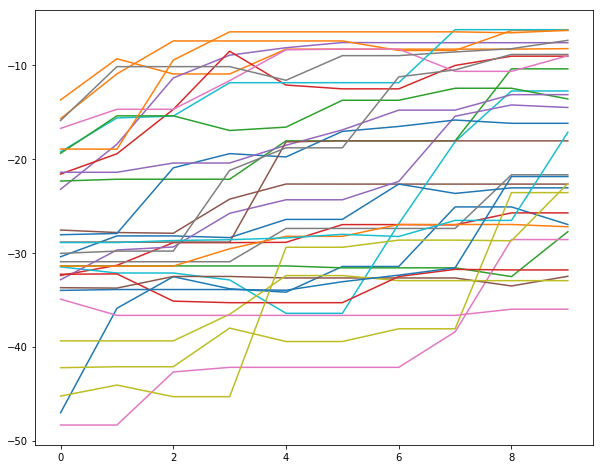

In [18]:
chain = np.loadtxt('aiphe.run.mcmc')
plot_logp(chain)

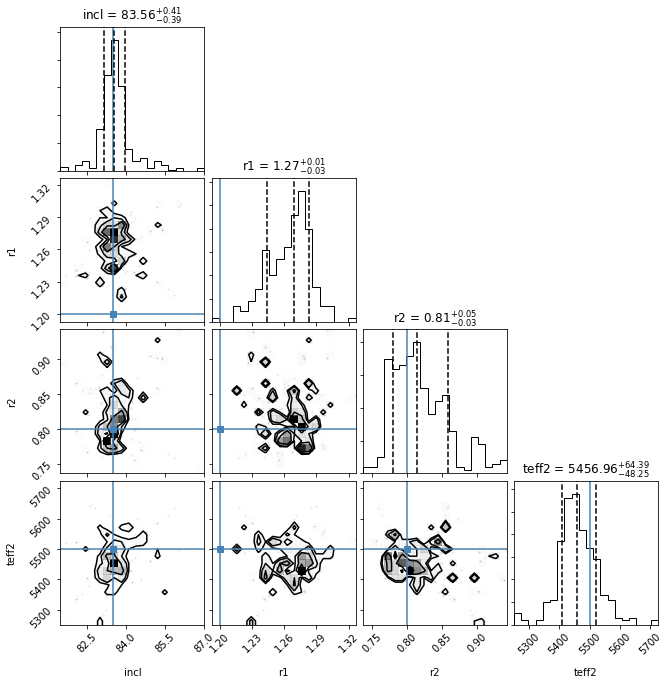

In [19]:
plot_posteriors(chain, ['incl', 'r1', 'r2', 'teff2'], truths = [83.5, 1.2, 0.8, 5500.], skipiters=0)